# Creating a Test Dataset

## Sampling Criteria

- English
- Focus only on monographic books (bib_fmt=='BK') and non-government docs
- Authors with more than 10 works. Inclusion in dataset capped at 100
- N is approximately 100,000 - a 150k selection is made, then cross-referenced with books available in EF

In [1]:
import pandas as pd
import dask
import dask.dataframe as dd
header_index = pd.read_csv('/data/hathifiles/header.txt', sep='\t').columns
# Grab the dtypes from the first few rows. HathiFiles are not cleanly exported, as far as I can tell, so 
# the dtype can be used to tells Pandas what to expect and throw out other cases
dtypes = pd.read_csv('/data/hathifiles/hathi_full_20190201.txt.gz', names=header_index, quoting=3,
                 compression='gzip', sep='\t', nrows=5000).dtypes.values
# Read as a dask dataframe
meta = dd.read_csv('/data/hathifiles/hathi_chunk_20190201.*.txt.gz', names=header_index,
                   compression='gzip', sep='\t', blocksize=None, dtype=dtypes)

In [5]:
seed1, seed2 = 54321, 86420

In [ ]:
min_books = 10 # Authors with fewer books are excluded
max_books = 100 # Authors with more books are included, but capped
total_sample_size = 150000

eng = meta[meta.lang == 'eng']
just_bk = eng[eng.bib_fmt == 'BK']
drop_govt = just_bk[just_bk.us_gov_doc_flag != '1']

author_counts = drop_govt.author.value_counts().compute()
top_authors = author_counts[author_counts >= min_books]
# cap authors at 100, randomize, and select enough to collect 150k books
top_authors[top_authors > max_books] = max_books 
top_authors = top_authors.sample(frac=1, random_state=seed1)
author_sample = top_authors[top_authors.cumsum() <= total_sample_size].index

truncate_authors = drop_govt[drop_govt.author.isin(author_sample)]

# For each author, sort their books and keep only 100
capped_books = truncate_authors.groupby('author').apply(lambda x: x.sample(frac=1, random_state=seed2).head(max_books) )

In [ ]:
df = capped_books.compute()
df.sample(4)

Check if there is an Extracted Features Dataset file for each book, and save the final dataset.

In [ ]:
import os
from htrc_features import utils
ef_exists = df.htid.apply(lambda x: '/data/extracted-features/' + utils.id_to_rsync(x)).apply(os.path.exists)

In [30]:
df[ef_exists].to_csv('test_dataset.csv.gz', compression='gzip', index=False)

In [50]:
df[ef_exists].htid.to_csv('test_dataset_htids.csv', index=False, header=False, quoting=3, sep=" ")

In [51]:
df[ef_exists].htid.apply(utils.id_to_rsync).to_csv('test_dataset_paths.csv', index=False, header=False, quoting=3, sep=" ")

In [46]:
import csv
csv.QUOTE_NONE

3

In [ ]:
df

## Dataset Stats

Number of volumes:

In [12]:
df.shape[0], df[ef_exists].shape[0]

(149995, 143864)

Number of unique authors:

In [14]:
a = df[ef_exists].author.value_counts()
a.size

6129

Number of authors without a date - usually organizations, sometimes classic authors like `Homer`:

In [15]:
no_date = a[~a.index.str.contains('\d')]
print("# of no date authors:", no_date.size, "\n# of books by those authors", no_date.sum(), "\nExample of authors: ", no_date.sample(5).index.tolist())

# of no date authors: 2055 
# of books by those authors 39213 
Example of authors:  ['Swift & Company.', 'Goldston, Robert C.', 'Quibria, M. G.', 'Food and Agriculture Organization of the United Nations.', 'Smith, William A.']



Number of books that seem to have non-English titles.

*This language classification was originally done as part of the sampling, but I removed it because it did not make a big impact, while adding complexity to a sampling process that is ideally simple.*

In [28]:
import langid
title_lang = df[ef_exists].title.apply(lambda x: langid.classify(x))
keep_choice = title_lang.apply(lambda x: (x[0] == 'en') or (x[1] > -150))
df[ef_exists].shape[0] - keep_choice.sum()

854

Distribution of authors by # of books represented.

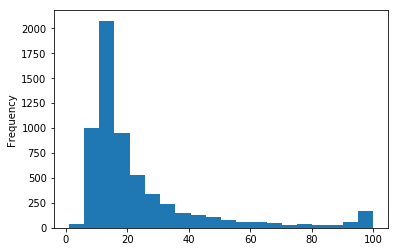

In [29]:
%matplotlib inline
a.plot(kind='hist', bins=20)

Number of author+title combos that are duplicated exactly:

In [17]:
dedupe = df[ef_exists][['title', 'author']].drop_duplicates()
df[ef_exists].shape[0] - dedupe.drop_duplicates().shape[0]

60190

Authors with most exact duplicates:

In [18]:
(a-dedupe.author.value_counts()).sort_values(ascending=False).head(10)

Kürschner, Joseph, 1853-1902.                                                                       99
Shortt, Adam, 1859-1931,                                                                            98
Boston (Mass.). Registry Department.                                                                98
Euler, Leonhard, 1707-1783                                                                          97
Parry, Clive                                                                                        96
Bell, John, 1745-1831.                                                                              88
Great Britain. Public Record Office                                                                 88
McQuillin, Eugene, 1860-1937.                                                                       87
Great Britain. Ministry of Public Buildings and Works. Ancient Monuments and Historic Buildings.    82
Henry, Robert, 1718-1790.                                                

For example, here are the unique titles by one of the most redundant authors. Variants in the titles show that the author+title deduping is only good for a rough estimation:

In [27]:
df[df.author.str.contains('Shortt')].groupby('title')[['author']].count()

,author
title,
Canada and its provinces : a history of the Canadian people and their institutions / by one hundred associates. General editors: Adam Shortt and Arthur G. Doughty.,19
"Canada and its provinces; a history of the Canadian people and their institutions, by one hundred associates. Adam Shortt, Arthur G. Doughty, general editors.",81
